# Model Deployment
The purpose of the model deployment phase in a model development process is to take a trained and validated machine learning model and make it available for use in a real-world environment. This phase involves integrating the model into production systems so it can generate predictions on new, unseen data. The main goals are:

- Operationalizing the model so it can be accessed by end-users, applications, or business processes.
- Ensuring the model runs efficiently, reliably, and securely in the target environment.
- Monitoring the model’s performance over time to detect data drift or performance degradation.
- Enabling updates, retraining, or rollback as needed based on new data or requirements.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data And Base Model

In [2]:
## Load data
input_folder = "../.local/analysis_pipeline/data_exploration"
inference_data = pd.read_parquet(f"{input_folder}/inference_data_09162025.parquet")

## Load model
from xgboost import XGBRegressor
input_folder = "../.local/analysis_pipeline/model_selection"
model = XGBRegressor()
model.load_model(f"{input_folder}/xgb_tweedie_model.json")

## Predict On The Inference Data

In [3]:
# Import xgboost for model prediction (not strictly needed for XGBRegressor, but kept for reference)
import xgboost as xgb

# Define the list of predictor variables (should match those used in model training)
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']

# Select the predictor columns from the inference data
X = inference_data[pred_lst].copy()

# Convert object columns to 'category' dtype if needed (for compatibility, especially if used during training)
for col in ['gender', 'area', 'veh_body']:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Predict using the loaded XGBRegressor model
pred = model.predict(X)

# Store the predictions in a new column in the inference_data DataFrame
inference_data['xgb_tweedie_pred'] = pred

In [4]:
# Reorder the predictors in inference_data according to their variable importances
pred_lst = ['credit_score', 'veh_age', 'gender', 'agecat2', 'veh_value', 'area', 'veh_body', 'traffic_index']
inference_data = inference_data[['quote_number']+pred_lst+['veh_cnt','pol_year','xgb_tweedie_pred']]


## Sign risk levels to the quotes

In [5]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck

# Select training samples for predictiveness check
data = inference_data

# Define variables
exp_var = 'veh_cnt'
pred_var = 'xgb_tweedie_pred'
var_1 = 'xgb_tweedie_pred'
var_2 = None
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

# Assign risk bins to quotes in the inference data
pc.binning(nbins=nbins)
processed_inference_data = pc.binned_data

## Inference Via Top Reasons


--- Predictiveness Plot for credit_score ---


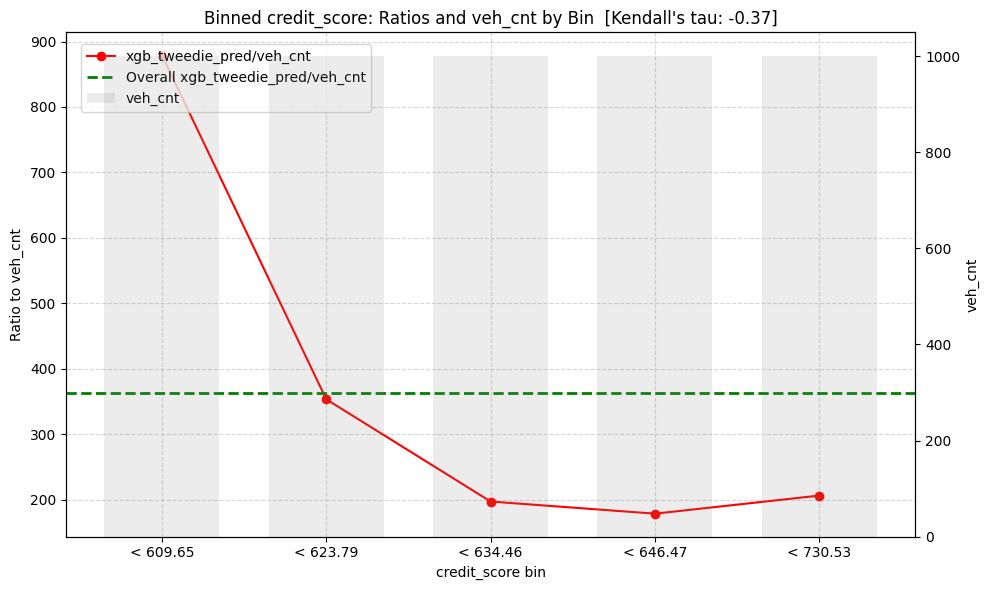


--- Predictiveness Plot for veh_age ---


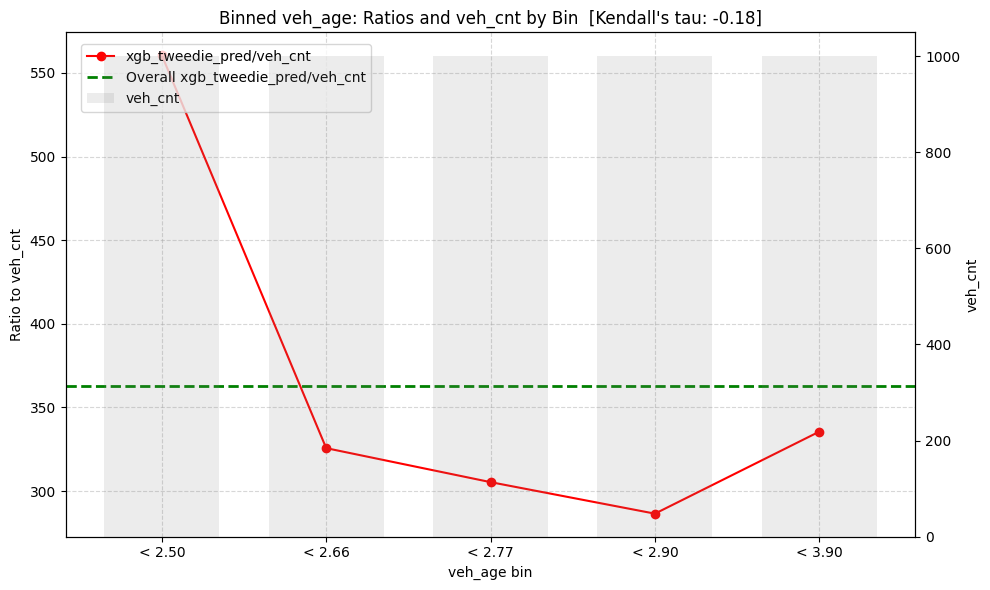


--- Predictiveness Plot for gender ---


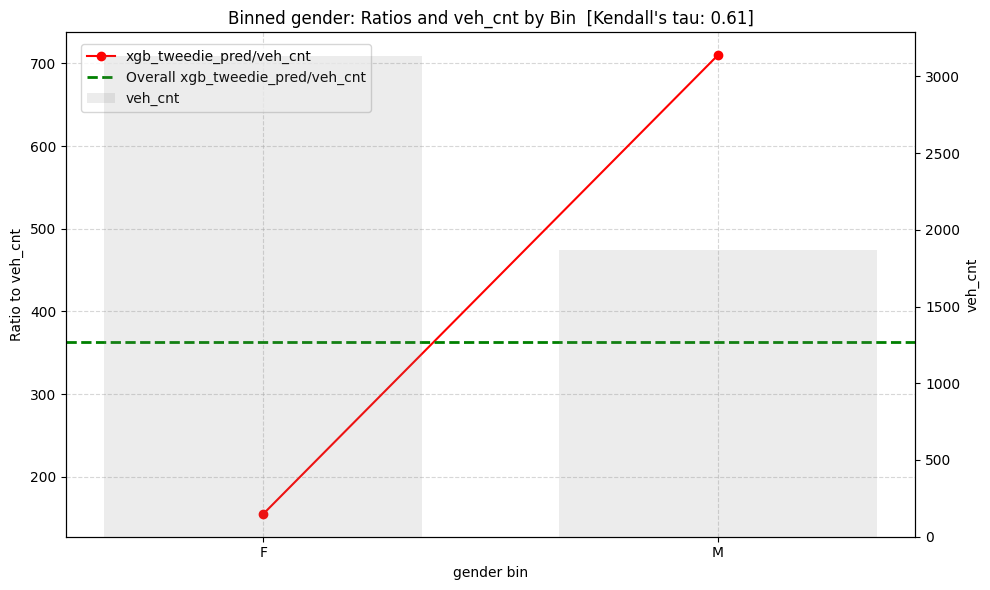


--- Predictiveness Plot for agecat2 ---


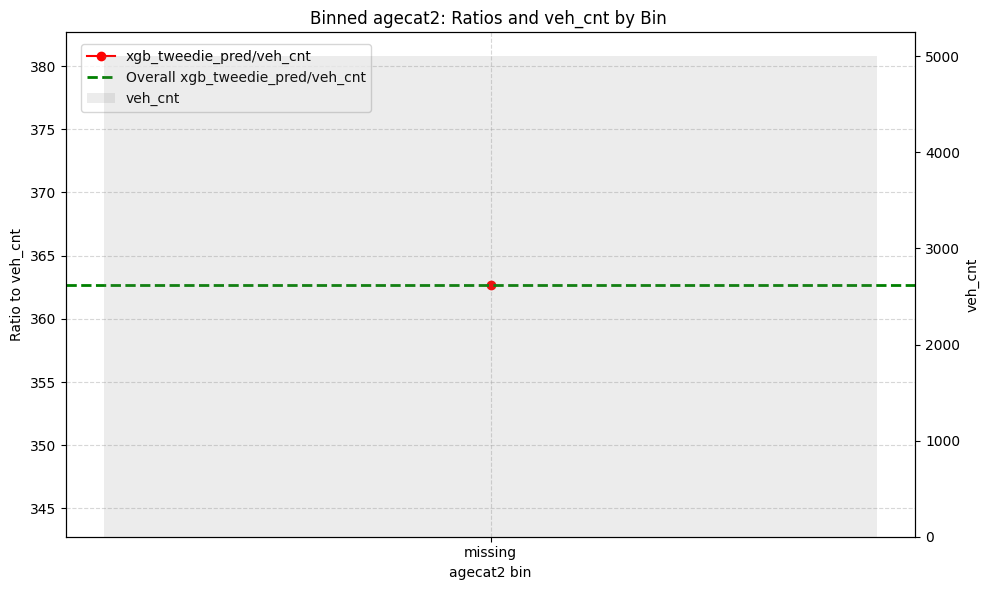


--- Predictiveness Plot for veh_value ---


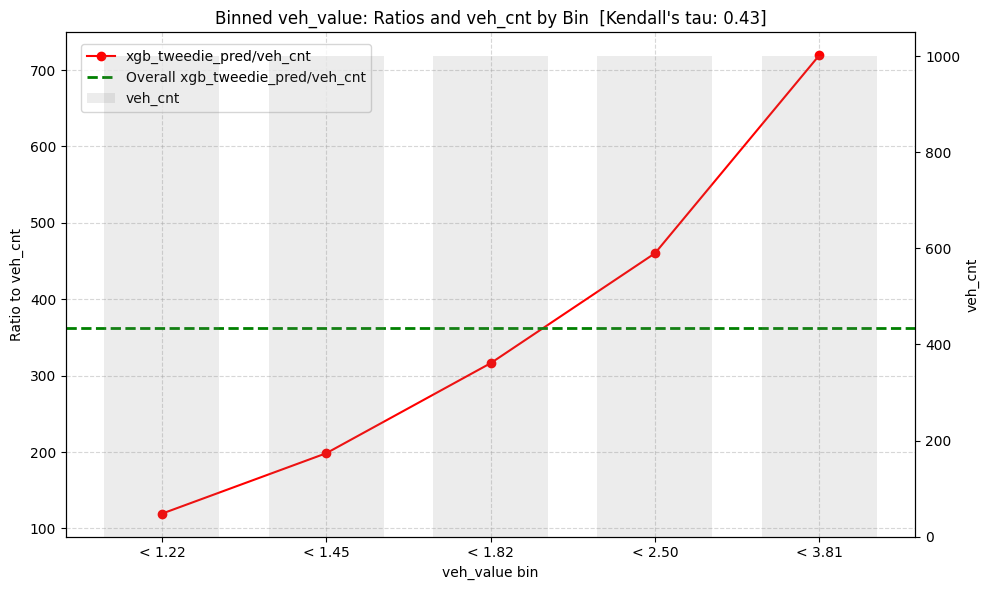


--- Predictiveness Plot for area ---


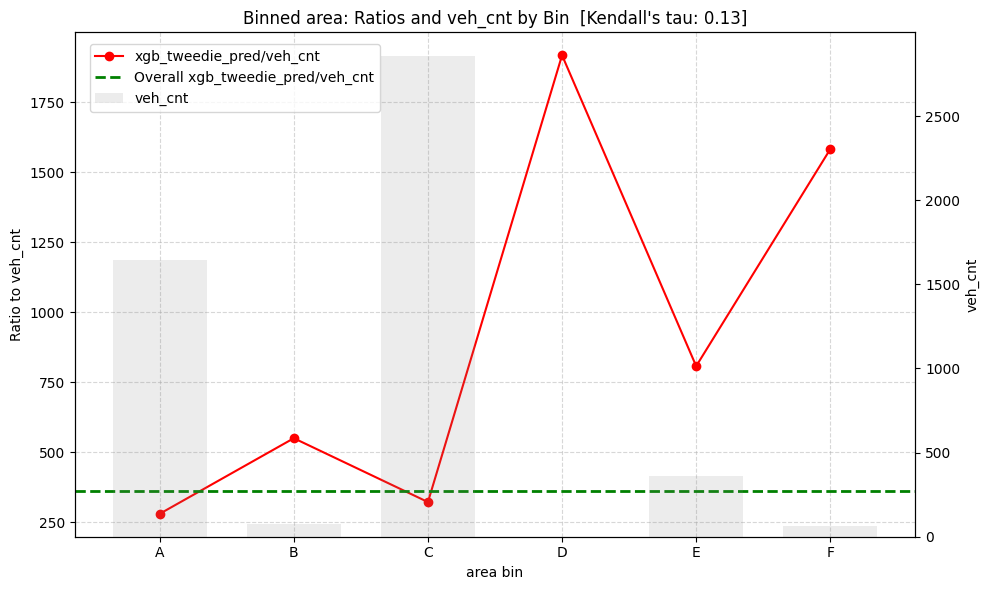


--- Predictiveness Plot for veh_body ---


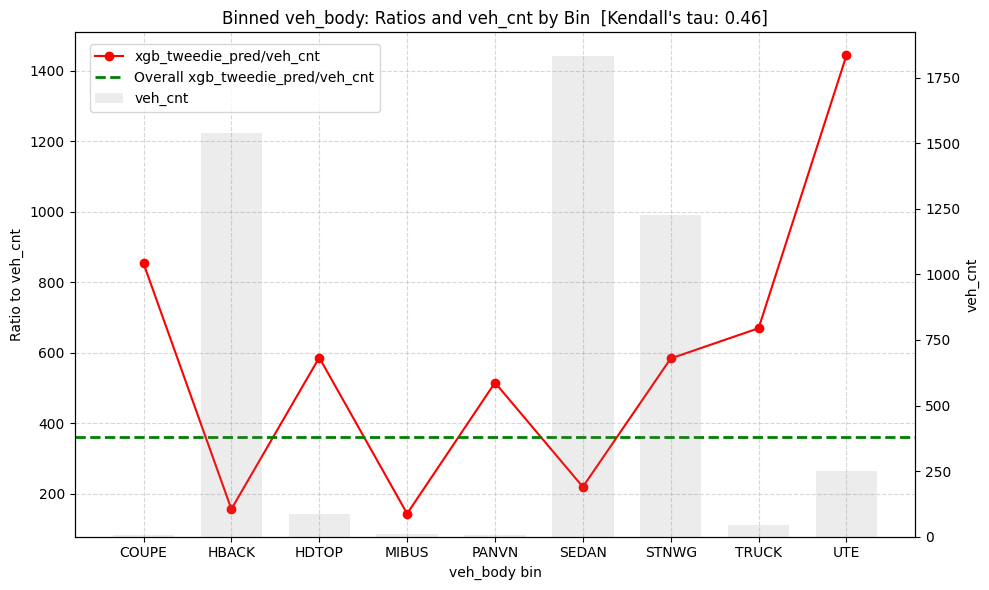


--- Predictiveness Plot for traffic_index ---


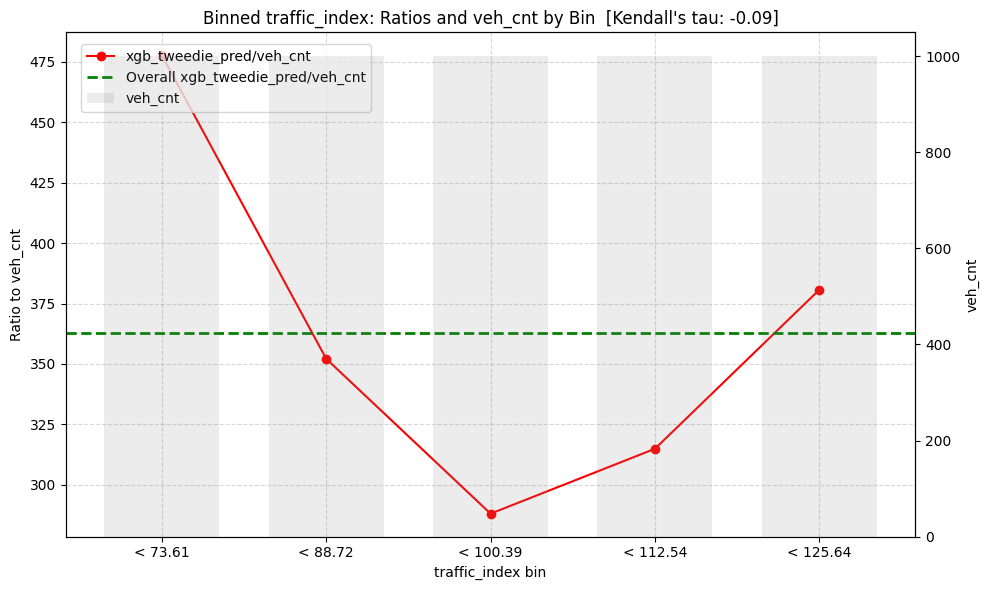

In [6]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
data = processed_inference_data
exp_var = 'veh_cnt' 
var_1 = 'xgb_tweedie_pred'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all(var_1_color='red')

In [7]:
# processed_inference_data.loc[processed_inference_data['bin']==9, :]
processed_inference_data.loc[processed_inference_data['quote_number']==28490739, :]

,quote_number,credit_score,veh_age,gender,agecat2,veh_value,area,veh_body,traffic_index,veh_cnt,pol_year,xgb_tweedie_pred,bin


#### Analysis on quote number 28490739
- credit_score  = 341   -> <span style="color:red"><b><i>   $1600 -> Credit socre is very bad (less than 560)        </i></b></span>
- veh_age       = 4     -> <span style="color:green"><b><i> $-300 -> Age of vehicle is not low (4)                   </i></b></span>
- gender        = F     -> <span style="color:green"><b><i> $-200 -> Driver is female                                </i></b></span>
- veh_value     = 1.221 -> <span style="color:green"><b><i> $-250 -> Vehicle value is not high (9.9k - 14.4k)        </i></b></span>
- area          = D     -> <span style="color:red"><b><i>    $400 -> Driver's are of residence is risker (D)         </i></b></span>
- veh_body      = UTE   -> <span style="color:red"><b><i>    $200 -> Utility vehicle type                            </i></b></span>
- traffic_index = 122.5 -> <span style="color:red"><b><i>     $30 -> Relatively heavy traffic area (119.4 - 137.3)   </i></b></span>

<span style="color:red"><b><i>Task 6: Use SHAP values and Waterfall plots to derive top reaons for individual quote. Specific to-dos are </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/1705.07874.</i></b></span>
2. <span style="color:red"><b><i>Read and try the SHAP value method described in this blog: https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/03_xgb_combined_shap_key_features.html. Note that we only need to handle individual case. Global predictor impact session and other sessions are beneficial but not necessary. </i></b></span>